# Reservoir Computer Lyapunov Exponents as $\rho$ changes (paper version)

### ( datasets by $\rho \in A =$ list of values  )

In [1]:
# Import libraries
import math     as math
import numpy    as np
import networkx as nx
import random   as random
import pandas   as pd
import matplotlib.pyplot as plt 
import time     as time

#######################################################################
# E N V I R O N M E N T   S E T   U P
#######################################################################
#---------------------------------------------------------------------#
# To compute elapsed time
#---------------------------------------------------------------------#
start_time = time.time()

## variables description
    D       :(int  ) Input data dimension      
    N       :(int  ) Reservoir dimension (degrees of freedome of the reservoir)       
    rhoSR   :(float) Spectral Radius of A      
    rhoA    :(float) Density of A              
    alpha   :(float) Leak (or leakage) rate in (0,1]                 
    sigma   :(float) Strength of input signal            
    sigmab  :(float) Strength of input bias               
    beta    :(float) Tichonov-Miller regularization parameter
    
    washout :(int)   During training, skipped transitory timesteps in W_out calculation
    spinup  :(int)   Time (n. of timesteps) it takes for a trained RC to converge from its initial condition
                     onto the synchronization manifold to which it is driven by the input data
    normtime:(int)   Range to skip some QR factorisations and speed up the calculations  
            
    r       :(float) Reservoir state
    W_in    :(float) Input matrix              
    A       :(float) Reservoir ajacency matrix 
    b       :(float) bias vector               
    W_out   :(float) Output matrix  
    endtr_r :(float) Last reservoir state in training
    
    R       :(float) Matrix containing r(t) for all t in training dataset
    U       :(float) Matrix containing u(t) for all t in training dataset
    u       :(float) Time series at time t
    v       :(float) Prediction


In [2]:
# ReservoirComputer class declaration
class ReservoirComputer:
    def __init__(self, D, N, rhoSR, rhoA, alpha, sigma, sigmab, beta):
        self.r      = np.zeros(N)
        self.W_in   = get_random_matrix(N, D, xa=-sigma, xb=sigma, nonzero=False)
        self.A      = generate_adjacency_matrix(N, rhoSR, rhoA)
        self.b      = sigmab * np.ones(N)
        self.W_out  = np.zeros((D,N))
        self.endtr_r= np.zeros(N)

    def rc_update_rule(self, y):
        # driven     mode: y = u(t)         ;r(t+1) = F^d_r (r(t),y)
        # autonomous mode: y = W_out . r(t) ;r(t+1) = F^a_r (r(t),y)
        g      = np.dot(self.A, self.r) + np.dot(self.W_in, y) + self.b
        self.r = alpha * np.tanh(g) + (1 - alpha) * self.r

    def update_v(self):
        return np.dot(self.W_out, self.r)

    def train(self, U, washout):
        steps = U.shape[0]
        R     = np.zeros((N, steps))
        for i in range(steps):
            R[:, i] = self.r
            u       = U[i]
            self.rc_update_rule(u)
        self.W_out = linear_regression(R[:,washout:], U[washout:], beta)
        self.endtr_r = self.r # save last training r state

    def spinup(self, U, steps):
        self.r = self.endtr_r # reset reservoir state
        if steps > 0:
            for i in range(steps):
                u = U[i]
                self.rc_update_rule(u) # driven mode
    
    def predict(self, steps):
        prediction = np.zeros((steps, D))
        for i in range(steps):
            v             = self.update_v()
            prediction[i] = v
            self.rc_update_rule(v)
        return prediction

    def rc_lyapunov_exponents(self, steps, dt, normtime):
        save_r = self.r # save r state
        self.r = self.endtr_r # reset r state
        lyap   = np.zeros((N,steps))
        M      = np.eye(N)
        W      = self.A + np.dot(self.W_in,self.W_out)
        j      = -1
        for i in range(steps):
            v     = self.update_v()
            self.rc_update_rule(v) # update r
            #
            g     = np.dot(W, self.r) + self.b
            DF    = alpha * np.dot(np.diag(1 - np.tanh(g)**2),W) \
                    + (1 - alpha) * np.eye(N)
            Mn    = np.dot(DF,M)
            if (i % normtime == 0):
                Q,Rii = np.linalg.qr(Mn)
                j     += 1
                lyap[:,j] = np.log(abs(np.diag(Rii)))
                M = Q
        L = np.sum(lyap,1) / ((j+1)*dt)    
        self.r = save_r # retrieve saved r_state
        return L

    def rc_conditional_lyapunov_exponents(self, U, dt, normtime):
        save_r = self.r # save r state
        self.r = np.zeros(N) # reset r state
        steps  = U.shape[0]
        lyap   = np.zeros((N,steps))
        M      = np.eye(N)
        j      = -1
        for i in range(steps):
            u       = U[i]
            self.rc_update_rule(u) # update r
            #
            g  = np.dot(self.A, self.r) + np.dot(self.W_in, u) + self.b
            DF = alpha * np.dot(np.diag(1 - np.tanh(g)**2),self.A) \
                 + (1 - alpha) * np.eye(N)
            Mn = np.dot(DF,M)
            if (i % normtime == 0):
                Q,Rii = np.linalg.qr(Mn)
                j     += 1
                lyap[:,j] = np.log(abs(np.diag(Rii)))
                M = Q
        CL = np.sum(lyap,1) / ((j+1)*dt)
        self.r = save_r # retrieve saved r_state
        return CL
    
# Helper functions
def generate_adjacency_matrix(N, rhoSR, rhoA):
    # Erdos-Reyni network
    graph = nx.gnp_random_graph(N, rhoA)
    adj   = nx.to_numpy_array(graph)
    # Ensure random_array is of the same shape as the graph adjacency matrix
    random_array = get_random_matrix(N, N, xa =-0.5, xb=0.5, nonzero=True)
    # Multiply graph adjacency matrix with random values
    rescaled     = adj * random_array
    return scale_matrix(rescaled, rhoSR)

def get_random_matrix(nrow, ncol, xa, xb, nonzero):
    B = np.zeros((nrow,ncol))
    for i in range(nrow):
        for j in range(ncol):
            if nonzero:
                while B[i,j] == 0:
                    B[i,j] = xa + (xb - xa) * np.random.rand()
            else:
                B[i,j] = xa + (xb - xa) * np.random.rand()
    return B

def scale_matrix(A, rhoSR):
    eigenvalues = np.linalg.eigvals(A)    # compute eigenvlaues
    sr = np.max(np.absolute(eigenvalues)) # compute spectral radius of A
    if sr > 0:
        A = A * rhoSR / sr                # rescaling matrix if A non zero
    return A

def linear_regression(R, U, beta=.0001): 
    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + beta * np.identity(R.shape[0]))
    return np.dot(np.dot(U.T, Rt), inverse_part)


In [3]:
#######################################################################
# R . C .  H Y P E R P A R A M E T E R   L I S T
#######################################################################
rnd_seed = 167

df_RC_HP = pd.concat([pd.read_csv('climate/df_RC200_seed' + str(rnd_seed) + '_HP_parte01.csv',delimiter=";",index_col=False),
                      pd.read_csv('climate/df_RC200_seed' + str(rnd_seed) + '_HP_parte02.csv',delimiter=";",index_col=False),
                      pd.read_csv('climate/df_RC200_seed' + str(rnd_seed) + '_HP_parte03.csv',delimiter=";",index_col=False),
                      pd.read_csv('climate/df_RC200_seed' + str(rnd_seed) + '_HP_parte04.csv',delimiter=";",index_col=False),
                      pd.read_csv('climate/df_RC200_seed' + str(rnd_seed) + '_HP_parte05.csv',delimiter=";",index_col=False),
                      pd.read_csv('climate/df_RC200_seed' + str(rnd_seed) + '_HP_parte06.csv',delimiter=";",index_col=False)],
                     ignore_index = True)

#df_RC_HP = pd.concat([pd.read_csv('climate/df_RC200_seed' + str(rnd_seed) + '_HP_parte06.csv',delimiter=";",index_col=False)],
#                     ignore_index = True)

len_df_RC_HP = len(df_RC_HP)
df_RC_HP = df_RC_HP.astype({'D':'int'})
df_RC_HP = df_RC_HP.astype({'N':'int'})
df_RC_HP = df_RC_HP.astype({'washout':'int'})

rho_list = df_RC_HP.rho_Lorenz

In [4]:
#######################################################################
# M A I N   L O O P 
#######################################################################
dt = 0.01
RC_LE     = np.zeros((len_df_RC_HP, 3)) #3 = Lorenz system dimension
maxCLE    = np.zeros(len_df_RC_HP)      # max CLE list

for s in range(len_df_RC_HP):
    rho_Lorenz  = df_RC_HP.iloc[s].rho_Lorenz
    # read dataset
    str_rho_Lorenz = (f'{rho_Lorenz:07.3f}').replace(".", "_")
    #print("===== ",f'{s:>4d}) : Lorenz rho = {rho_Lorenz:>7.3f}')
    X = np.loadtxt('dataset/Lorenz_Dataset_'+str(str_rho_Lorenz)+'.csv',delimiter=";")
    n_timesteps = len(X)
    #print(n_timesteps)
    
    # splitting in training and test dataset
    data_length          = len(X) 
    training_percentage  = .8
    training_data_length = round(training_percentage * data_length) 
    #print("data_length          =",data_length)
    #print("training_data_length =",training_data_length)
    training_data = np.array(X[:training_data_length])
    test_data     = np.array(X[training_data_length:])

    # Setting random seed for repeteability
    np.random.seed(rnd_seed)
    random.seed(rnd_seed)    
    
    # set hyperparameter from cartesian product
    D      = round(df_RC_HP.iloc[s].D)
    N      = round(df_RC_HP.iloc[s].N)
    rhoSR  = df_RC_HP.iloc[s].rhoSR
    rhoA   = df_RC_HP.iloc[s].rhoA
    alpha  = df_RC_HP.iloc[s].alpha 
    sigma  = df_RC_HP.iloc[s].sigma
    sigmab = df_RC_HP.iloc[s].sigmab 
    beta   = df_RC_HP.iloc[s].beta
    #
    model   = ReservoirComputer(D, N, rhoSR, rhoA, alpha, sigma, sigmab, beta)
    # training
    washout = round(df_RC_HP.iloc[s].washout) # transitory skipped timesteps
    model.train(training_data, washout)    
    
    # compute RC Lyapunov Exponents
    normtime = 1
    L = model.rc_lyapunov_exponents(len(test_data), dt, normtime)
    RC_LE[s] = L[:D] 
    
    # compute RC Conditional Lyapunov Exponents
    normtime = 1
    CL = model.rc_conditional_lyapunov_exponents(training_data, dt, normtime)
    maxCLE[s] = np.max(CL)   
    
    print(f'{s:>4d}) : Lorenz rho = {rho_Lorenz:>7.3f}',"RC Lyapunov Exponents",RC_LE[s]," max CLE", maxCLE[s])
    
    del model


   0) : Lorenz rho =   0.000 RC Lyapunov Exponents [ -1.13885945  -2.74406173 -36.60573497]  max CLE -37.16610211305644
   1) : Lorenz rho =   1.000 RC Lyapunov Exponents [ -0.17499064  -2.88348132 -26.4395977 ]  max CLE -28.60205854137808
   2) : Lorenz rho =   2.000 RC Lyapunov Exponents [ -1.27959555  -1.30045457 -58.50766704]  max CLE -77.37811133304913
   3) : Lorenz rho =   3.000 RC Lyapunov Exponents [ -1.22913437  -1.1903012  -30.71012836]  max CLE -48.1459268068289
   4) : Lorenz rho =   4.000 RC Lyapunov Exponents [ -1.13483699  -1.11023303 -24.72285979]  max CLE -46.71462509083227
   5) : Lorenz rho =   5.000 RC Lyapunov Exponents [ -1.01205266  -0.989501   -41.93641178]  max CLE -91.69283442185497
   6) : Lorenz rho =   6.000 RC Lyapunov Exponents [ -0.94057747  -0.92682323 -34.74528366]  max CLE -97.4887924531756
   7) : Lorenz rho =   7.000 RC Lyapunov Exponents [ -0.83168504  -0.84307137 -38.03088684]  max CLE -143.9275953075999
   8) : Lorenz rho =   8.000 RC Lyapunov E

  68) : Lorenz rho =  63.000 RC Lyapunov Exponents [  1.38037265   0.04895848 -15.35441726]  max CLE -46.80470294632631
  69) : Lorenz rho =  64.000 RC Lyapunov Exponents [  1.40183827  -0.05225253 -14.51021594]  max CLE -82.39442014824235
  70) : Lorenz rho =  65.000 RC Lyapunov Exponents [  1.40979514   0.10642848 -14.58831452]  max CLE -82.48052849802043
  71) : Lorenz rho =  66.000 RC Lyapunov Exponents [  1.42859443  -0.06201107 -14.97447117]  max CLE -82.74667821146406
  72) : Lorenz rho =  67.000 RC Lyapunov Exponents [  1.27412257   0.14585732 -15.62168701]  max CLE -40.8066042200316
  73) : Lorenz rho =  68.000 RC Lyapunov Exponents [  1.28253673   0.21788773 -15.17322134]  max CLE -82.90052962835911
  74) : Lorenz rho =  69.000 RC Lyapunov Exponents [  1.1149232    0.08638857 -14.48231134]  max CLE -41.027339186903745
  75) : Lorenz rho =  70.000 RC Lyapunov Exponents [  1.79830783  -0.06416051 -15.27269894]  max CLE -47.10592073819206
  76) : Lorenz rho =  71.000 RC Lyapunov

 137) : Lorenz rho = 130.000 RC Lyapunov Exponents [  1.6656893    0.42618395 -12.3104721 ]  max CLE -86.48991667250436
 138) : Lorenz rho = 131.000 RC Lyapunov Exponents [  7.8384537   -1.56360087 -17.17194432]  max CLE -76.66523919469053
 139) : Lorenz rho = 132.000 RC Lyapunov Exponents [  1.18316139   0.24854189 -19.72796631]  max CLE -48.624759717283176
 140) : Lorenz rho = 133.000 RC Lyapunov Exponents [  3.50190033  -4.13883447 -20.32760362]  max CLE -147.69037133075543
 141) : Lorenz rho = 134.000 RC Lyapunov Exponents [  0.45634876   0.06916563 -15.40154509]  max CLE -144.82242079703178
 142) : Lorenz rho = 135.000 RC Lyapunov Exponents [ -40.43022717  -40.83918848 -150.41309088]  max CLE -147.98691747165557
 143) : Lorenz rho = 136.000 RC Lyapunov Exponents [-3.19177726 -3.71620551 -6.01346896]  max CLE -80.45826894898602
 144) : Lorenz rho = 137.000 RC Lyapunov Exponents [  1.85994872   0.02562745 -14.79661642]  max CLE -86.6554317172003
 145) : Lorenz rho = 138.000 RC Lyapu

 206) : Lorenz rho = 197.000 RC Lyapunov Exponents [  1.73076536  -2.84100161 -12.16335313]  max CLE -88.21319755161667
 207) : Lorenz rho = 198.000 RC Lyapunov Exponents [ 1.48836258 -0.35102568 -9.03162343]  max CLE -88.17562485501644
 208) : Lorenz rho = 199.000 RC Lyapunov Exponents [ 1.97630149 -2.85042474 -7.35744782]  max CLE -88.21120176786772
 209) : Lorenz rho = 200.000 RC Lyapunov Exponents [ -0.93923519  -1.31394271 -41.27536155]  max CLE -151.7400283563159
 210) : Lorenz rho = 201.000 RC Lyapunov Exponents [  1.11303944   0.09995356 -10.49910932]  max CLE -87.91427361138398
 211) : Lorenz rho = 202.000 RC Lyapunov Exponents [  1.68065478  -0.44730784 -11.93173995]  max CLE -83.73432430277646
 212) : Lorenz rho = 203.000 RC Lyapunov Exponents [ 11.54335217  -8.5590528  -28.16767073]  max CLE -47.33809373010906
 213) : Lorenz rho = 204.000 RC Lyapunov Exponents [  -7.23867266   -7.95166084 -150.75443525]  max CLE -150.14173460826197
 214) : Lorenz rho = 205.000 RC Lyapunov E

 275) : Lorenz rho = 264.000 RC Lyapunov Exponents [  0.19914982  -1.37152777 -25.77646468]  max CLE -50.08351351902218
 276) : Lorenz rho = 265.000 RC Lyapunov Exponents [  0.24312891  -1.22376024 -20.46595757]  max CLE -50.061040057867714
 277) : Lorenz rho = 266.000 RC Lyapunov Exponents [  0.15737745  -1.76738231 -23.0496882 ]  max CLE -50.08590351671417
 278) : Lorenz rho = 267.000 RC Lyapunov Exponents [  0.39523974  -2.73581717 -13.87434942]  max CLE -49.099568309387685
 279) : Lorenz rho = 268.000 RC Lyapunov Exponents [  0.48115611  -1.2911731  -81.60409084]  max CLE -155.58736743895014
 280) : Lorenz rho = 269.000 RC Lyapunov Exponents [  0.23770656  -8.91502385 -16.06147823]  max CLE -50.157862361040095
 281) : Lorenz rho = 270.000 RC Lyapunov Exponents [ 0.22265767 -1.69340402 -6.84630493]  max CLE -49.100927252458675
 282) : Lorenz rho = 271.000 RC Lyapunov Exponents [  0.17552737  -0.7466361  -17.82043596]  max CLE -48.91258098957731
 283) : Lorenz rho = 272.000 RC Lyapun

In [5]:
# Convert numpy array to pandas DataFrame
df_RC_LE = pd.DataFrame(RC_LE)

# Name columns
df_RC_LE.columns =['lambda_1', 'lambda_2', 'lambda_3']

# Using DataFrame.insert() to add a column
df_RC_LE.insert(0, "rho_Lorenz",rho_list, True)

# Using DataFrame.insert() to add a column
df_RC_LE.insert(len(df_RC_LE.columns),"maxCLE",maxCLE, True)

# Save DataFrame to .csv
df_RC_LE.to_csv('climate/df_RC200_seed' + str(rnd_seed) + '_LE_PAPER.csv', index=False, header=True, decimal='.', sep=';')


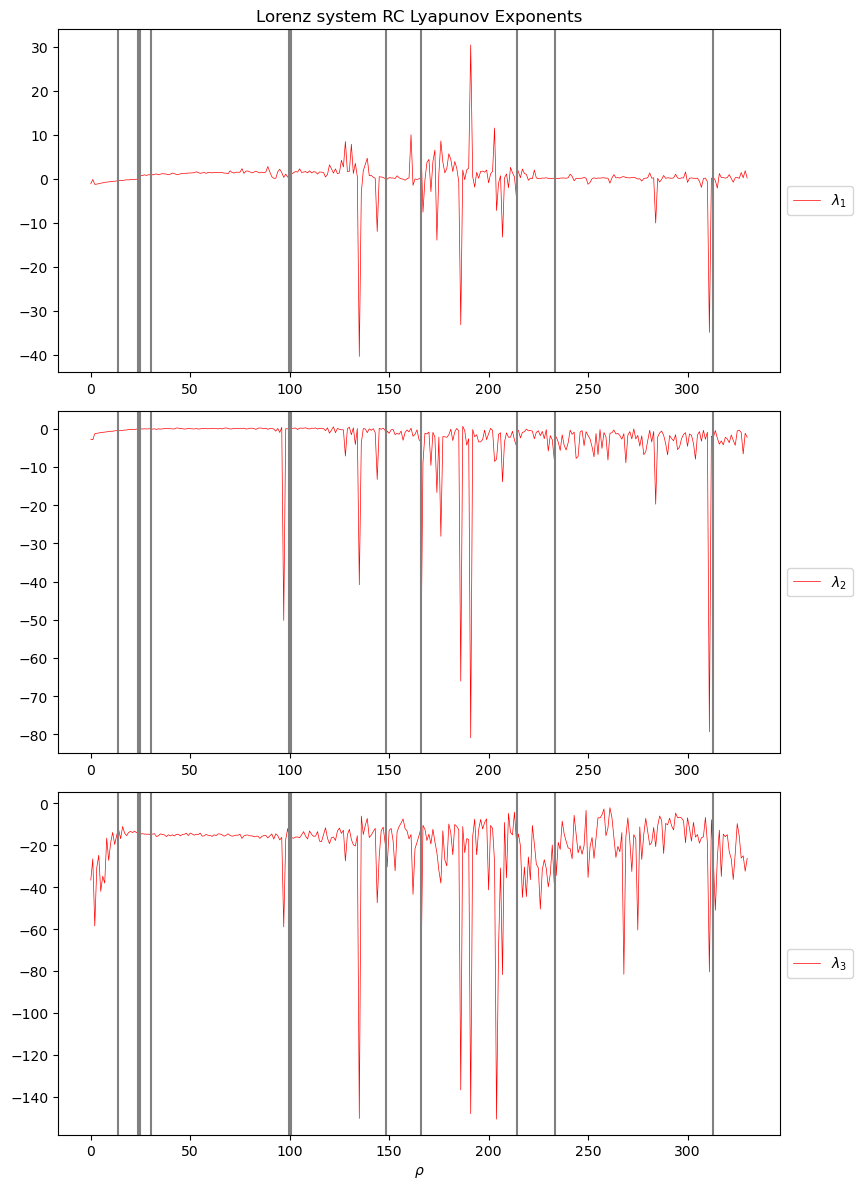

In [6]:
# Plot Lorenz system Lyapunov Exponents
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  

axis_test_label = ["$\lambda_1$"     ,"$\lambda_2$"     ,"$\lambda_3$"     ]
axs[0].set_title("Lorenz system RC Lyapunov Exponents")

for i in range(D):
    axs[i].plot(rho_list, RC_LE[:,i] , label= axis_test_label[i], color='red' , lw = 0.5)
    #
    # Shrink current axis by 20%
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    axs[i].axvline(x = 13.926667, color = 'grey')
    axs[i].axvline(x = 23.926667, color = 'grey')
    axs[i].axvline(x = 24.058   , color = 'grey')
    axs[i].axvline(x = 470./19. , color = 'grey')
    axs[i].axvline(x = 30.485   , color = 'grey')
    
    axs[i].axvline(x = 99.524   , color = 'grey')
    axs[i].axvline(x = 100.795  , color = 'grey')
    axs[i].axvline(x = 148.4    , color = 'grey')
    axs[i].axvline(x = 166.07   , color = 'grey')
    axs[i].axvline(x = 214.364  , color = 'grey')
    axs[i].axvline(x = 233.5    , color = 'grey')
    axs[i].axvline(x = 313      , color = 'grey')
    
axs[2].set_xlabel("$\\rho$") #\\rho need to prevent parsing error!!!
fig.tight_layout()

plt.show()

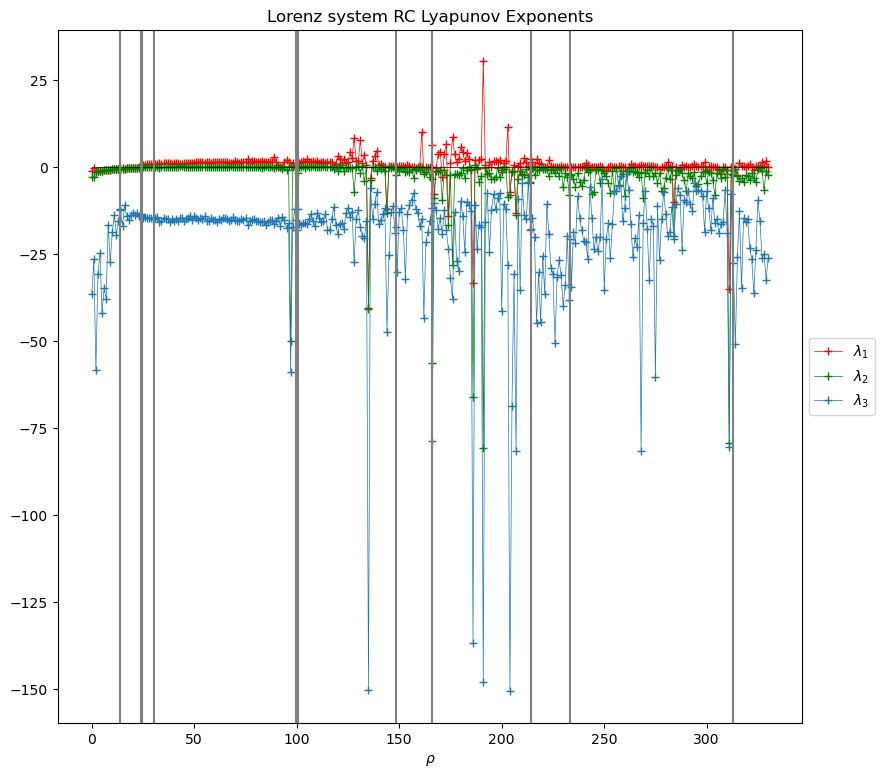

In [7]:
# Plot Lorenz system Lyapunov Exponents
fig = plt.figure(figsize = (12, 9)) 
ax  = fig.add_subplot(1, 1, 1)

axis_test_label = ["$\lambda_1$"     ,"$\lambda_2$"     ,"$\lambda_3$"     ]
ax.set_title("Lorenz system RC Lyapunov Exponents")

ax.plot(rho_list, RC_LE[:,0] , label= axis_test_label[0], color='red'  , marker='+',lw = 0.5)
ax.plot(rho_list, RC_LE[:,1] , label= axis_test_label[1], color='green', marker='+',lw = 0.5)
ax.plot(rho_list, RC_LE[:,2] , label= axis_test_label[2], color='C0'   , marker='+',lw = 0.5)
ax.plot(rho_list, 0*RC_LE[:,0], color='black', lw = 0.5)
#
ax.axvline(x = 13.926667, color = 'grey')
ax.axvline(x = 23.926667, color = 'grey')
ax.axvline(x = 24.058   , color = 'grey')
ax.axvline(x = 470./19. , color = 'grey')
ax.axvline(x = 30.485   , color = 'grey')
#
ax.axvline(x = 99.524   , color = 'grey')
ax.axvline(x = 100.795  , color = 'grey')
ax.axvline(x = 148.4    , color = 'grey')
ax.axvline(x = 166.07   , color = 'grey')
ax.axvline(x = 214.364  , color = 'grey')
ax.axvline(x = 233.5    , color = 'grey')
ax.axvline(x = 313      , color = 'grey')
#
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("$\\rho$") #\\rho need to prevent parsing error!!!

plt.show()

In [8]:
#---------------------------------------------------------------------#---------------------------------------------------------------------#
# Elapsed time
#---------------------------------------------------------------------#
print(f'\nElapsed time {time.time() - start_time:6.2e} s')


Elapsed time 2.12e+04 s
